# Using Dask to process MEaSUREs Gridded Sea Surface Height Anomalies Version 1812

Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>

Use parallel computing using Dask within the AWS cloud. This code can only be ran in the AWS US-West-2. 

The used dataset is 

In [8]:
import xarray as xr
import numpy as np
import h5py
import pylab as plt
import pandas as pd
#Short_name is used to identify a specific dataset in NASA Earthdata. 
short_name='SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812'

In [3]:
def init_S3FileSystem():
    import requests,s3fs
    creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    return s3

def return_token():
    import requests
    s3_cred_endpoint = {
        'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
        'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'}

    temp_creds_url = s3_cred_endpoint['podaac']
    creds = requests.get(temp_creds_url).json()
    return creds

In [9]:
s3sys=init_S3FileSystem()
fns=s3sys.glob("s3://podaac-ops-cumulus-protected/%s/*.nc"%short_name)
print(fns[0])
time=pd.date_range(start='1992-10-02',periods=len(fns),freq='7D')

podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_1992100212.nc


In [5]:
d=xr.open_dataset(s3sys.open(fns[0]))
d['SLA'].mean().values

array(-0.00536335, dtype=float32)

In [5]:
def calc_mean(fn_s3,s3sys):
    with xr.open_dataset(s3sys.open(fn_s3))['SLA'] as d:
        dout=d.mean.data
    return dout

## Using a single thread

CPU times: user 4min 20s, sys: 51.6 s, total: 5min 12s
Wall time: 17min 17s


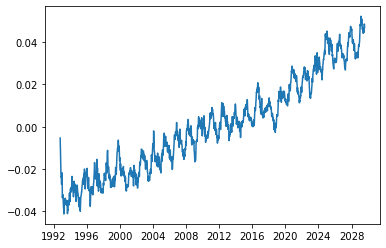

In [10]:
%%time

result=[]

for fn in fns:
    result.append(calc_mean(fn,s3sys) )
plt.plot(time,np.array(result).squeeze())


In [11]:
from dask.distributed import Client
from dask import delayed,compute
client = Client(n_workers=32)

2022-06-14 04:33:58,054 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jpluser/Jinbo_folder/the-coding-club/notebooks/dask-worker-space/worker-7u16nvp6', purging


In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 32
Total threads: 32,Total memory: 58.74 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36243,Workers: 32
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 58.74 GiB
Comm: tcp://127.0.0.1:38625,Total threads: 1
Dashboard: http://127.0.0.1:43749/status,Memory: 1.84 GiB
Nanny: tcp://127.0.0.1:45991,


In [13]:
print('There are %i files.'%len(fns))

There are 1922 files.


CPU times: user 22.9 s, sys: 4.67 s, total: 27.6 s
Wall time: 42.7 s


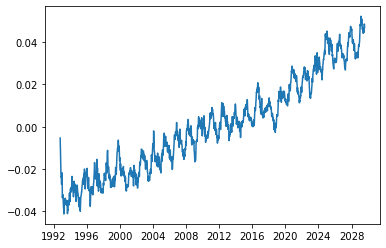

In [14]:
%%time

result=[]

for fn in fns:
    result.append(delayed(calc_mean)(fn,s3sys) )

output=np.array(compute(result)).squeeze()

plt.plot(time,output)


In [13]:
client.shutdown()

2022-06-14 04:11:46,199 - tornado.application - ERROR - Exception in callback <bound method Client._heartbeat of <Client: 'tcp://127.0.0.1:34857' processes=32 threads=128, memory=234.97 GiB>>
Traceback (most recent call last):
  File "/home/jpluser/conda/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/home/jpluser/conda/lib/python3.9/site-packages/distributed/client.py", line 1339, in _heartbeat
    self.scheduler_comm.send({"op": "heartbeat-client"})
  File "/home/jpluser/conda/lib/python3.9/site-packages/distributed/batched.py", line 137, in send
    raise CommClosedError(f"Comm {self.comm!r} already closed.")
distributed.comm.core.CommClosedError: Comm <TCP (closed) Client->Scheduler local=tcp://127.0.0.1:51256 remote=tcp://127.0.0.1:34857> already closed.
